In [1]:
import numpy as np
import pandas as pd
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import deque
import random

In [2]:

data = pd.read_csv('data.csv')
data['datetime'] = pd.to_datetime(data['datetime'])

X = data.drop(['signal', 'datetime'], axis=1) 
y = data['signal'].map({'buy': 0, 'sell': 1, 'none': 2}).astype(int) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# Initialize Deep Q-Learning agents
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  
        self.epsilon = 1.0  
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(24, input_dim=self.state_size, activation='relu'),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dense(self.action_size, activation='linear')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)  # Use learning_rate instead of lr
        model.compile(loss='mse', optimizer=optimizer)
        return model


    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


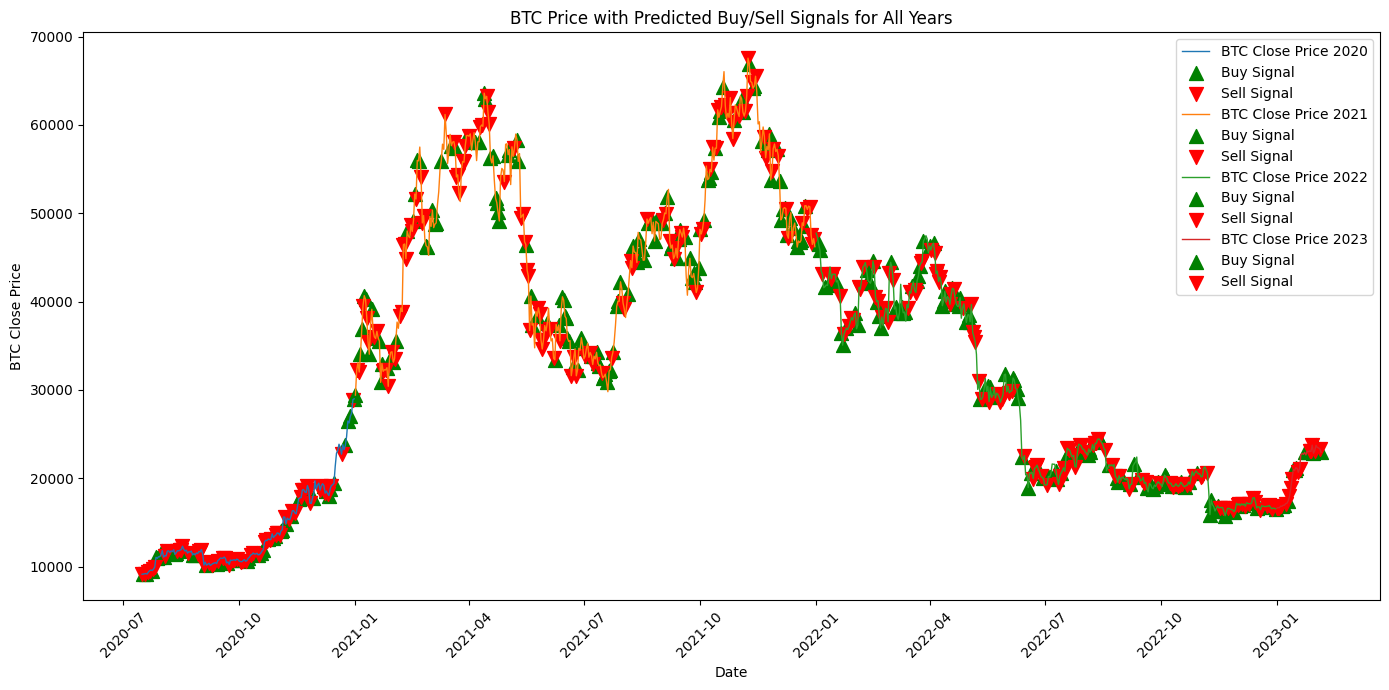

In [9]:
num_agents = 5  
agents = [DQNAgent(X_train_scaled.shape[1], 3) for _ in range(num_agents)]

# Train agents
num_episodes = 1000  
batch_size = 32 
for episode in range(num_episodes):
    for agent in agents:
        agent.replay(batch_size)

# Plotting BTC close price with predicted signals for all years
plt.figure(figsize=(14, 7))

# Iterate over each year
for year in data['datetime'].dt.year.unique():
    year_data = data[data['datetime'].dt.year == year]
    plt.plot(year_data['datetime'], year_data['close'], label=f'BTC Close Price {year}', linewidth=1)

    for agent in agents:
        X_year_scaled = scaler.transform(year_data.drop(['signal', 'datetime'], axis=1))
        predicted_signal = [agent.act(np.array([scaled_features])) for scaled_features in X_year_scaled]
        buy_signals_indices = np.where(np.array(predicted_signal) == 0)[0]
        sell_signals_indices = np.where(np.array(predicted_signal) == 1)[0]

        buy_signals = year_data.iloc[buy_signals_indices]
        sell_signals = year_data.iloc[sell_signals_indices]

    plt.scatter(buy_signals['datetime'], buy_signals['close'], label='Buy Signal', marker='^', color='green', alpha=1, s=100)
    plt.scatter(sell_signals['datetime'], sell_signals['close'], label='Sell Signal', marker='v', color='red', alpha=1, s=100)

plt.title('BTC Price with Predicted Buy/Sell Signals for All Years')
plt.xlabel('Date')
plt.ylabel('BTC Close Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import accuracy_score, precision_score

true_labels = []
predicted_labels = []

for year in data['datetime'].dt.year.unique():
    year_data = data[data['datetime'].dt.year == year]

    for agent in agents:
        X_year_scaled = scaler.transform(year_data.drop(['signal', 'datetime'], axis=1))
        predicted_signal = [agent.act(np.array([scaled_features])) for scaled_features in X_year_scaled]

        predicted_labels.extend(['buy' if signal == 0 else 'sell' if signal == 1 else 'none' for signal in predicted_signal])
        
        true_labels.extend(list(year_data['signal']))

true_labels_numeric = [0 if label == 'buy' else 1 if label == 'sell' else 2 for label in true_labels]
predicted_labels_numeric = [0 if label == 'buy' else 1 if label == 'sell' else 2 for label in predicted_labels]

accuracy = accuracy_score(true_labels_numeric, predicted_labels_numeric)

precision = precision_score(true_labels, predicted_labels, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)


Accuracy: 0.3336898395721925
Precision: 0.6935020685558297
